In [1]:
"""
NeuralGates - A library for implementing logic gates and digital circuits using neural networks.

This library provides an easy-to-use interface for training neural network models
to behave like logical gates and combining them to create more complex digital circuits
like half adders and full adders.
"""

import random
import math
import matplotlib.pyplot as plt


# Define common logic gate truth tables
LOGIC_GATES = {
    "AND": [
        [0, 0, 0],
        [0, 1, 0],
        [1, 0, 0],
        [1, 1, 1]
    ],
    "OR": [
        [0, 0, 0],
        [0, 1, 1],
        [1, 0, 1],
        [1, 1, 1]
    ],
    "NAND": [
        [0, 0, 1],
        [0, 1, 1],
        [1, 0, 1],
        [1, 1, 0]
    ],
    "NOR": [
        [0, 0, 1],
        [0, 1, 0],
        [1, 0, 0],
        [1, 1, 0]
    ],
    "XOR": [
        [0, 0, 0],
        [0, 1, 1],
        [1, 0, 1],
        [1, 1, 0]
    ],
    "XNOR": [
        [0, 0, 1],
        [0, 1, 0],
        [1, 0, 0],
        [1, 1, 1]
    ]
}


class NeuralGate:
    """
    A neural network implementation of a logical gate.
    """
    def __init__(self, gate_type=None, seed=None):
        """
        Initialize a neural gate with random weights and biases.
        
        Args:
            gate_type (str, optional): Type of logic gate to train ("AND", "OR", "NAND", "XOR", etc).
            seed (int, optional): Random seed for reproducibility.
        """
        self.or_w1 = 0.0
        self.or_w2 = 0.0
        self.or_b = 0.0
        self.and_w1 = 0.0
        self.and_w2 = 0.0
        self.and_b = 0.0
        self.nand_w1 = 0.0
        self.nand_w2 = 0.0
        self.nand_b = 0.0
        
        # Initialize with random weights if seed is provided
        if seed is not None:
            self.initialize_random(seed)
            
        # Set gate type and training data
        self.gate_type = gate_type
        self.training_data = LOGIC_GATES.get(gate_type) if gate_type else None
        
        # Training metrics
        self.training_history = []
    
    def initialize_random(self, seed=42):
        """
        Initialize the weights with random values using a seed.
        
        Args:
            seed (int): Seed for the random number generator.
        """
        def rand_no(s):
            random.seed(seed + s)
            return random.random()
        
        self.or_w1 = rand_no(1)
        self.or_w2 = rand_no(2)
        self.or_b = rand_no(3)
        self.and_w1 = rand_no(4)
        self.and_w2 = rand_no(5)
        self.and_b = rand_no(6)
        self.nand_w1 = rand_no(7)
        self.nand_w2 = rand_no(8)
        self.nand_b = rand_no(9)
    
    def forward(self, x1, x2):
        """
        Forward pass through the neural network.
        
        Args:
            x1 (float): First input.
            x2 (float): Second input.
            
        Returns:
            float: Output of the neural network.
        """
        a = math.tanh(x1 * self.or_w1 + x2 * self.or_w2 + self.or_b)
        b = math.tanh(x1 * self.nand_w1 + x2 * self.nand_w2 + self.nand_b)
        return math.tanh(a * self.and_w1 + b * self.and_w2 + self.and_b)
    
    def cost(self, training_data=None):
        """
        Calculate the cost/error of the model on training data.
        
        Args:
            training_data (list, optional): Training data in format [[x1, x2, y], ...].
                If not provided, uses the gate's training data.
                
        Returns:
            float: Mean squared error.
        """
        data = training_data if training_data is not None else self.training_data
        if data is None:
            raise ValueError("No training data provided")
            
        result = 0.0
        for x in data:
            x1, x2, target = x
            y = self.forward(x1, x2)
            d = y - target
            result += d * d
        return result / len(data)
    
    def finite_diff(self, training_data=None, h=0.0001):
        """
        Calculate gradients using finite differences.
        
        Args:
            training_data (list, optional): Training data.
            h (float): Small value for derivative approximation.
            
        Returns:
            NeuralGate: A NeuralGate object containing gradients.
        """
        data = training_data if training_data is not None else self.training_data
        if data is None:
            raise ValueError("No training data provided")
            
        g = NeuralGate()
        c = self.cost(data)
        
        # Calculate gradients for OR weights
        params = [
            ('or_w1', 'or_w1'), ('or_w2', 'or_w2'), ('or_b', 'or_b'),
            ('and_w1', 'and_w1'), ('and_w2', 'and_w2'), ('and_b', 'and_b'),
            ('nand_w1', 'nand_w1'), ('nand_w2', 'nand_w2'), ('nand_b', 'nand_b')
        ]
        
        for param_name, grad_name in params:
            saved = getattr(self, param_name)
            setattr(self, param_name, saved + h)
            setattr(g, grad_name, (self.cost(data) - c) / h)
            setattr(self, param_name, saved)
            
        return g
    
    def adapt(self, gradients, learning_rate=0.01):
        """
        Update weights based on gradients.
        
        Args:
            gradients (NeuralGate): Gradient values.
            learning_rate (float): Learning rate.
            
        Returns:
            self: The updated model.
        """
        params = [
            'or_w1', 'or_w2', 'or_b',
            'and_w1', 'and_w2', 'and_b',
            'nand_w1', 'nand_w2', 'nand_b'
        ]
        
        for param in params:
            current_value = getattr(self, param)
            gradient_value = getattr(gradients, param)
            setattr(self, param, current_value - gradient_value * learning_rate)
            
        return self
    
    def train(self, epochs=10000, learning_rate=0.1, training_data=None, verbose=False, log_interval=1000):
        """
        Train the neural network on the specified logic gate.
        
        Args:
            epochs (int): Number of training epochs.
            learning_rate (float): Learning rate.
            training_data (list, optional): Custom training data.
            verbose (bool): Whether to print progress.
            log_interval (int): How often to log progress.
            
        Returns:
            list: Training history (cost at each logged epoch).
        """
        data = training_data if training_data is not None else self.training_data
        if data is None:
            raise ValueError("No training data provided")
            
        self.training_history = []
        
        for epoch in range(epochs):
            # Calculate gradients and update weights
            gradients = self.finite_diff(data)
            self.adapt(gradients, learning_rate)
            
            # Log progress
            if epoch % log_interval == 0 or epoch == epochs - 1:
                cost = self.cost(data)
                self.training_history.append(cost)
                if verbose:
                    print(f"Epoch {epoch}: Cost = {cost:.8f}")
                    
        return self.training_history
    
    def predict(self, x1, x2):
        """
        Make a binary prediction (0 or 1) for inputs based on the rounded output.
        
        Args:
            x1 (float): First input.
            x2 (float): Second input.
            
        Returns:
            int: Binary prediction (0 or 1).
        """
        output = self.forward(x1, x2)
        return round(output)
    
    def evaluate(self, training_data=None):
        """
        Evaluate the model on all input combinations and print the results.
        
        Args:
            training_data (list, optional): Data to evaluate on.
            
        Returns:
            dict: Dictionary with evaluation metrics.
        """
        data = training_data if training_data is not None else self.training_data
        if data is None:
            data = [[0, 0, None], [0, 1, None], [1, 0, None], [1, 1, None]]
        
        print(f"{'Input 1':^8} | {'Input 2':^8} | {'Target':^8} | {'Output':^8} | {'Prediction':^10}")
        print("-" * 50)
        
        correct = 0
        for x in data:
            x1, x2 = x[0], x[1]
            target = x[2] if len(x) > 2 else None
            output = self.forward(x1, x2)
            prediction = round(output)
            
            if target is not None and prediction == target:
                correct += 1
                
            target_str = f"{target}" if target is not None else "N/A"
            print(f"{x1:^8} | {x2:^8} | {target_str:^8} | {output:^8.4f} | {prediction:^10}")
        
        metrics = {}
        if data[0][2] is not None:  # If targets are provided
            metrics['accuracy'] = correct / len(data)
            print(f"\nAccuracy: {metrics['accuracy'] * 100:.2f}%")
            
        return metrics
    
    def plot_training_history(self):
        """
        Plot the training history (cost over epochs).
        """
        if not self.training_history:
            print("No training history available.")
            return
            
        plt.figure(figsize=(10, 6))
        plt.plot(range(0, len(self.training_history)), self.training_history)
        plt.title(f"Training History ({self.gate_type if self.gate_type else 'Custom'} Gate)")
        plt.xlabel("Logged Epochs")
        plt.ylabel("Cost (MSE)")
        plt.grid(True)
        plt.yscale('log')
        plt.show()
    
    def get_parameters(self):
        """
        Get the parameters of the model.
        
        Returns:
            dict: Dictionary containing all parameters.
        """
        return {
            'or_w1': self.or_w1,
            'or_w2': self.or_w2,
            'or_b': self.or_b,
            'and_w1': self.and_w1,
            'and_w2': self.and_w2,
            'and_b': self.and_b,
            'nand_w1': self.nand_w1,
            'nand_w2': self.nand_w2,
            'nand_b': self.nand_b,
        }
    
    def set_parameters(self, params):
        """
        Set the parameters of the model.
        
        Args:
            params (dict): Dictionary containing parameters.
            
        Returns:
            self: The updated model.
        """
        for key, value in params.items():
            if hasattr(self, key):
                setattr(self, key, value)
        return self
    
    
    def __str__(self):
        """String representation of the model."""
        gate_type = self.gate_type if self.gate_type else "Custom"
        cost = self.cost(self.training_data) if self.training_data else "N/A"
        return f"NeuralGate({gate_type}) - Cost: {cost}"


class HalfAdder:
    """
    Neural network implementation of a half adder.
    """
    def __init__(self, seed=None):
        """
        Initialize a half adder with sum (XOR) and carry (AND) gates.
        
        Args:
            seed (int, optional): Random seed for reproducibility.
        """
        self.sum_gate = NeuralGate(gate_type="XOR", seed=seed)
        self.carry_gate = NeuralGate(gate_type="AND", seed=seed if seed is None else seed + 10)
    
    def train(self, epochs=10000, learning_rate=0.1, verbose=False):
        """
        Train both gates of the half adder.
        
        Args:
            epochs (int): Number of training epochs.
            learning_rate (float): Learning rate.
            verbose (bool): Whether to print progress.
            
        Returns:
            tuple: Training history for sum and carry gates.
        """
        print("Training SUM gate (XOR)...")
        sum_history = self.sum_gate.train(epochs, learning_rate, verbose=verbose)
        
        print("\nTraining CARRY gate (AND)...")
        carry_history = self.carry_gate.train(epochs, learning_rate, verbose=verbose)
        
        return sum_history, carry_history
    
    def compute(self, x1, x2):
        """
        Compute the sum and carry for the half adder.
        
        Args:
            x1 (int): First input bit.
            x2 (int): Second input bit.
            
        Returns:
            tuple: (sum bit, carry bit)
        """
        sum_bit = self.sum_gate.predict(x1, x2)
        carry_bit = self.carry_gate.predict(x1, x2)
        return sum_bit, carry_bit
    
    def evaluate(self):
        """Evaluate the half adder on all input combinations."""
        print("HALF ADDER EVALUATION")
        print("=====================")
        print(f"{'Input 1':^8} | {'Input 2':^8} | {'Sum':^8} | {'Carry':^8}")
        print("-" * 40)
        
        for i in range(2):
            for j in range(2):
                sum_bit, carry_bit = self.compute(i, j)
                print(f"{i:^8} | {j:^8} | {sum_bit:^8} | {carry_bit:^8}")
    

#Do not go gentle into that good night.
#Rage, rage against the dying of the light

class FullAdder:
    """
    Neural network implementation of a full adder using two half adders.
    """
    def __init__(self, seed=None):
        """
        Initialize a full adder with two half adders and an OR gate.
        
        Args:
            seed (int, optional): Random seed for reproducibility.
        """
        self.first_half_adder = HalfAdder(seed=seed)
        self.second_half_adder = HalfAdder(seed=seed + 20 if seed is not None else None)
        self.or_gate = NeuralGate(gate_type="OR", seed=seed + 40 if seed is not None else None)
    
    def train(self, epochs=10000, learning_rate=0.1, verbose=False):
        """
        Train all components of the full adder.
        
        Args:
            epochs (int): Number of training epochs.
            learning_rate (float): Learning rate.
            verbose (bool): Whether to print progress.
        """
        print("Training first half adder...")
        self.first_half_adder.train(epochs, learning_rate, verbose=verbose)
        
        print("\nTraining second half adder...")
        self.second_half_adder.train(epochs, learning_rate, verbose=verbose)
        
        print("\nTraining OR gate...")
        self.or_gate.train(epochs, learning_rate, verbose=verbose)
    
    def compute(self, x1, x2, cin):
        """
        Compute the sum and carry for the full adder.
        
        Args:
            x1 (int): First input bit.
            x2 (int): Second input bit.
            cin (int): Carry-in bit.
            
        Returns:
            tuple: (sum bit, carry-out bit)
        """
        # First half adder: x1 + x2
        sum1, carry1 = self.first_half_adder.compute(x1, x2)
        
        # Second half adder: sum1 + cin
        sum2, carry2 = self.second_half_adder.compute(sum1, cin)
        
        # OR gate for the carry: carry1 OR carry2
        carry_out = self.or_gate.predict(carry1, carry2)
        
        return sum2, carry_out
    
    def evaluate(self):
        """Evaluate the full adder on all input combinations."""
        print("FULL ADDER EVALUATION")
        print("====================")
        print(f"{'Input 1':^8} | {'Input 2':^8} | {'Carry In':^8} | {'Sum':^8} | {'Carry Out':^10}")
        print("-" * 60)
        
        for i in range(2):
            for j in range(2):
                for k in range(2):
                    sum_bit, carry_out = self.compute(i, j, k)
                    print(f"{i:^8} | {j:^8} | {k:^8} | {sum_bit:^8} | {carry_out:^10}")
    
# yo! p

In [18]:
xor_gate = NeuralGate("XOR", 42)
xor_gate.cost()

0.33515420139659435

In [19]:
xor_gate.evaluate()

Input 1  | Input 2  |  Target  |  Output  | Prediction
--------------------------------------------------
   0     |    0     |    0     |  0.7003  |     1     
   0     |    1     |    1     |  0.8605  |     1     
   1     |    0     |    1     |  0.7265  |     1     
   1     |    1     |    0     |  0.8694  |     1     

Accuracy: 50.00%


{'accuracy': 0.5}

In [27]:
xor_gate.train()

[2.0269780082647748e-05,
 2.0035422270539055e-05,
 1.9822632580698138e-05,
 1.9629937245501533e-05,
 1.945600151279707e-05,
 1.9299613196617956e-05,
 1.9159668447766168e-05,
 1.903515940278316e-05,
 1.8925163428746843e-05,
 1.8828833729108948e-05,
 1.874546836411378e-05]

In [28]:
xor_gate.evaluate()

Input 1  | Input 2  |  Target  |  Output  | Prediction
--------------------------------------------------
   0     |    0     |    0     |  0.0001  |     0     
   0     |    1     |    1     |  0.9939  |     1     
   1     |    0     |    1     |  0.9939  |     1     
   1     |    1     |    0     |  0.0002  |     0     

Accuracy: 100.00%


{'accuracy': 1.0}

In [29]:
xor_gate.cost()

1.874546836411378e-05

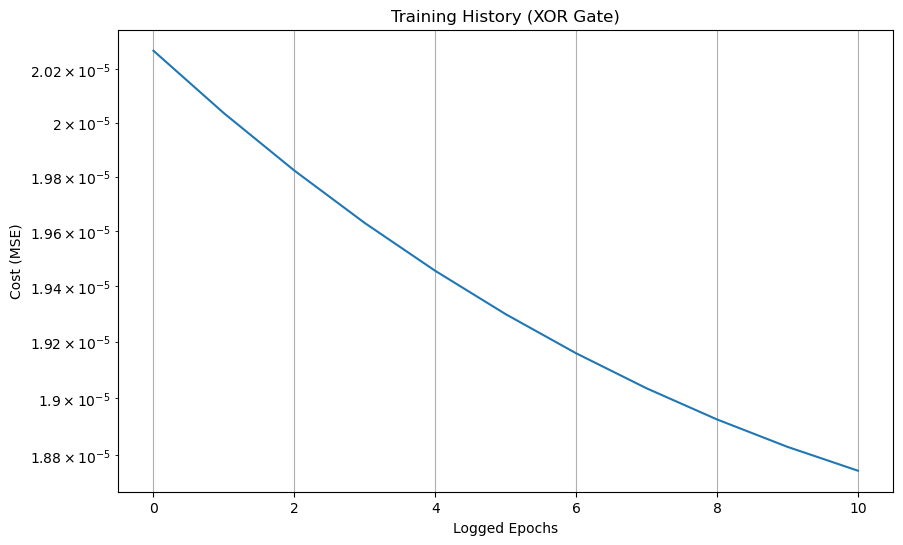

In [30]:
xor_gate.plot_training_history()

In [31]:
and_gate = NeuralGate("AND", 69)

In [33]:
and_gate.cost()

0.5393040361079976

In [34]:
and_gate.train()

[0.515583904919712,
 0.0015160240938294775,
 0.0004303714336051733,
 0.000241926754850315,
 0.0001665914248368046,
 0.00012654085442891577,
 0.00010184717902302042,
 8.516374738603538e-05,
 7.316864402293566e-05,
 6.414653527154182e-05,
 5.7130714439141484e-05]

In [36]:
and_gate.evaluate()

Input 1  | Input 2  |  Target  |  Output  | Prediction
--------------------------------------------------
   0     |    0     |    0     | -0.0001  |     0     
   0     |    1     |    0     |  0.0002  |     0     
   1     |    0     |    0     |  0.0002  |     0     
   1     |    1     |    1     |  0.9849  |     1     

Accuracy: 100.00%


{'accuracy': 1.0}

In [42]:
def half_adder():
    print(f"i1|i2  sum || carry")
    for i in range(2):
        for j in range(2):            
            print(f"{i} | {j} >  {xor_gate.predict(i,j)} || {and_gate.predict(i,j)}")
half_adder()  

i1|i2  sum || carry
0 | 0 >  0 || 0
0 | 1 >  1 || 0
1 | 0 >  1 || 0
1 | 1 >  0 || 1


In [43]:
or_gate = NeuralGate("OR", 20)    

In [44]:
or_gate.train()

[0.20333573338476174,
 0.0004778400478476477,
 0.00019958331283613257,
 0.0001239976629026343,
 8.93219717726144e-05,
 6.954787135909687e-05,
 5.6814897623716955e-05,
 4.7951000600591776e-05,
 4.1435560895051574e-05,
 3.645017417185194e-05,
 3.251947937678701e-05]

In [45]:
or_gate.evaluate()

Input 1  | Input 2  |  Target  |  Output  | Prediction
--------------------------------------------------
   0     |    0     |    0     |  0.0001  |     0     
   0     |    1     |    1     |  0.9922  |     1     
   1     |    0     |    1     |  0.9918  |     1     
   1     |    1     |    1     |  0.9983  |     1     

Accuracy: 100.00%


{'accuracy': 1.0}

In [55]:
def full_adder():
    print(f"i | j | k    s || co")
    print("="*18)
    for i in range(2):
        for j in range(2):
            for k in range(2):
                xo1 = xor_gate.predict(i,j)
                ao1 = and_gate.predict(i,j)
                xo2 = xor_gate.predict(xo1,k)
                ao2 = and_gate.predict(xo1,k)
                or_1 = or_gate.predict(ao1,ao2)

                sum_ = xo2
                cout = or_1
                                
                print(f"{i} | {j} | {k} >> {sum_} || {cout}")
full_adder()

i | j | k    s || co
0 | 0 | 0 >> 0 || 0
0 | 0 | 1 >> 1 || 0
0 | 1 | 0 >> 1 || 0
0 | 1 | 1 >> 0 || 1
1 | 0 | 0 >> 1 || 0
1 | 0 | 1 >> 0 || 1
1 | 1 | 0 >> 0 || 1
1 | 1 | 1 >> 1 || 1


In [81]:
def bit_adder(a,b):
    a_bit = [(a >> x) & 1 for x in range(4)]
    b_bit = [(b >> x) & 1 for x in range(4)]

    fa_list =[] 
    carry = 0
    
    for i in range(4):
        fa = FullAdder(seed=69 + i)
        fa.train(epochs=5000, learning_rate=0.1, verbose=False)
        fa_list.append(fa)

    result_bits = []
    for x in range(4):
        sum_bit, carry = fa_list[x].compute(a_bit[x], b_bit[x], carry)
        result_bits.append(sum_bit)

    #result_bits.append(carry)

    decimal_result = 0
    for i, bit in enumerate(result_bits):
        decimal_result += bit * (2 ** i)
            
        # Return binary representation and decimal value
    return result_bits[::-1], decimal_result
        

In [82]:
bit_adder(5,8)

Training first half adder...
Training SUM gate (XOR)...

Training CARRY gate (AND)...

Training second half adder...
Training SUM gate (XOR)...

Training CARRY gate (AND)...

Training OR gate...
Training first half adder...
Training SUM gate (XOR)...

Training CARRY gate (AND)...

Training second half adder...
Training SUM gate (XOR)...

Training CARRY gate (AND)...

Training OR gate...
Training first half adder...
Training SUM gate (XOR)...

Training CARRY gate (AND)...

Training second half adder...
Training SUM gate (XOR)...

Training CARRY gate (AND)...

Training OR gate...
Training first half adder...
Training SUM gate (XOR)...

Training CARRY gate (AND)...

Training second half adder...
Training SUM gate (XOR)...

Training CARRY gate (AND)...

Training OR gate...


([1, 1, 0, 1], 13)

In [73]:
bin(13)

'0b1101'

In [75]:
format(13, '04b')

'1101'